__Нейросетевая языковая модель на основе LSTM__ 

Евгений Борисов <esborisov@sevsu.ru>

Shivam Bansal   
Language Modelling and Text Generation using LSTMs — Deep Learning for NLP.    
Mar 26, 2018

https://medium.com/@shivambansal36/language-modelling-text-generation-using-lstms-deep-learning-for-nlp-ed36b224b275

In [1]:
# загружаем текст
import gzip
with gzip.open('../data/dostoevsky-besy-p2.txt.gz','rt',encoding='utf-8') as f: data = f.read()     
print(len(data))

465595


In [2]:
# print(data[:1024*100])

In [3]:
from nltk.tokenize import sent_tokenize as nltk_sentence_split
from nltk.tokenize import word_tokenize as nltk_tokenize_word

EOS = '<EOS>'
PAD = '<UNK>'

text = [ 
    nltk_tokenize_word(s,language='russian')+[EOS] # разбиваем предложения на слова
    for s in nltk_sentence_split(data,language='russian') # режем текст на отдельные предложения
]

del data

len(text)

5495

In [4]:
text = text[1:1024*4]
# text

In [5]:
import itertools

words = sorted( set(itertools.chain(*text)) - set([PAD,EOS]) )
word2index = { w:i+2 for i,w in enumerate(words) }
del words

word2index[PAD]=0
word2index[EOS]=1

index2word = { i:w for  w,i in word2index.items() }

total_words = len(word2index)

total_words

13585

In [6]:
# word2index[EOS]

In [7]:
import numpy as np
from keras.preprocessing.sequence import pad_sequences

min_seq_len = 3
max_seq_len = 17

n_grams = [
   [ word2index[token] for token in sentence[:i+min_seq_len][-max_seq_len:] ]
   for sentence in text
   for i in range(len(sentence)-min_seq_len+1)
]

sequences = np.array(pad_sequences(n_grams, maxlen=max_seq_len, padding='pre'))

del n_grams

sequences.shape

(64655, 17)

In [8]:
import keras.utils as ku 

inputs = sequences[:,:-1]
targets = sequences[:,-1]

del sequences

targets = ku.np_utils.to_categorical(targets, num_classes=total_words)

In [9]:
inputs.shape, inputs.dtype, targets.shape, targets.dtype

((64655, 16), dtype('int32'), (64655, 13585), dtype('float32'))

In [10]:
import tensorflow as tf 

from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers import Dense
# from keras.layers import Dropout
    
model = Sequential()
model.add(Embedding(total_words, 256, input_length=inputs.shape[1]))
model.add(LSTM(128, return_sequences = True))
# model.add(Dropout(0.2))
model.add(LSTM(96))
model.add(Dense(targets.shape[1], activation='softmax'))

model.compile(
    loss='categorical_crossentropy', 
#     optimizer=tf.optimizers.Adam(learning_rate=1e-4,),
    optimizer='adam',
    metrics=['accuracy']
)

2022-03-23 00:30:44.428068: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-23 00:30:44.485620: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-23 00:30:44.485826: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-23 00:30:44.486322: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [11]:
# from tensorflow.keras.utils import plot_model
# plot_model(model,to_file='cnn.png', show_layer_names=True, show_shapes=True )
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 16, 256)           3477760   
                                                                 
 lstm (LSTM)                 (None, 16, 128)           197120    
                                                                 
 lstm_1 (LSTM)               (None, 96)                86400     
                                                                 
 dense (Dense)               (None, 13585)             1317745   
                                                                 
Total params: 5,079,025
Trainable params: 5,079,025
Non-trainable params: 0
_________________________________________________________________


In [12]:
# targets.sum(axis=0).astype(int)

In [13]:
# from keras.callbacks import EarlyStopping
# callbacks = [ EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto'), ]

In [14]:
%%time 

epochs = 100

history = model.fit( 
    inputs,
    targets, 
    epochs=epochs, 
    verbose=1,
    # callbacks=callbacks,
    # validation_split=.1,
)

# 1min 30s

2022-03-23 00:30:45.489775: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3513352700 exceeds 10% of free system memory.
2022-03-23 00:30:47.721302: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3513352700 exceeds 10% of free system memory.


Epoch 1/100
   1/2021 [..............................] - ETA: 1:18:51 - loss: 9.5169 - accuracy: 0.0000e+00

2022-03-23 00:30:51.212853: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8300


2021/2021 [==============================] - 27s 12ms/step - loss: 6.7816 - accuracy: 0.1594
Epoch 2/100
2021/2021 [==============================] - 25s 12ms/step - loss: 6.1201 - accuracy: 0.1802
Epoch 3/100
2021/2021 [==============================] - 24s 12ms/step - loss: 5.8143 - accuracy: 0.1843
Epoch 4/100
2021/2021 [==============================] - 23s 11ms/step - loss: 5.5520 - accuracy: 0.1999
Epoch 5/100
2021/2021 [==============================] - 22s 11ms/step - loss: 5.3200 - accuracy: 0.2129
Epoch 6/100
2021/2021 [==============================] - 22s 11ms/step - loss: 5.0970 - accuracy: 0.2264
Epoch 7/100
2021/2021 [==============================] - 22s 11ms/step - loss: 4.8785 - accuracy: 0.2428
Epoch 8/100
2021/2021 [==============================] - 22s 11ms/step - loss: 4.6658 - accuracy: 0.2556
Epoch 9/100
2021/2021 [==============================] - 22s 11ms/step - loss: 4.4589 - accuracy: 0.2655
Epoch 10/100
2021/2021 [==============================] - 22s 11ms/

2021/2021 [==============================] - 23s 11ms/step - loss: 0.2352 - accuracy: 0.9448
Epoch 79/100
2021/2021 [==============================] - 23s 11ms/step - loss: 0.2314 - accuracy: 0.9454
Epoch 80/100
2021/2021 [==============================] - 24s 12ms/step - loss: 0.2267 - accuracy: 0.9459
Epoch 81/100
2021/2021 [==============================] - 24s 12ms/step - loss: 0.2216 - accuracy: 0.9473
Epoch 82/100
2021/2021 [==============================] - 24s 12ms/step - loss: 0.2153 - accuracy: 0.9499
Epoch 83/100
2021/2021 [==============================] - 24s 12ms/step - loss: 0.2138 - accuracy: 0.9492
Epoch 84/100
2021/2021 [==============================] - 23s 11ms/step - loss: 0.2089 - accuracy: 0.9506
Epoch 85/100
2021/2021 [==============================] - 23s 11ms/step - loss: 0.2053 - accuracy: 0.9501
Epoch 86/100
2021/2021 [==============================] - 23s 11ms/step - loss: 0.2028 - accuracy: 0.9505
Epoch 87/100
2021/2021 [==============================] - 2

In [15]:
# score = model.evaluate(x_test, y_test, verbose=False)
# print('Test accuracy:', score[1])

print( history.history.keys() )

dict_keys(['loss', 'accuracy'])


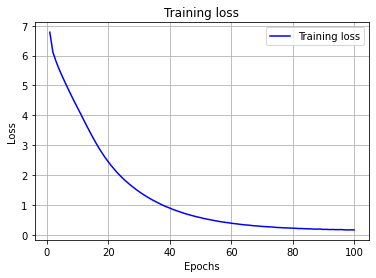

In [16]:
from matplotlib import pyplot as plt

loss = history.history['loss']
# val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'b', label='Training loss')
# plt.plot(epochs, val_loss, 'r', label='Validation loss')
# plt.title('Training and validation loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.show()

In [17]:
# plt.clf()   # clear figure

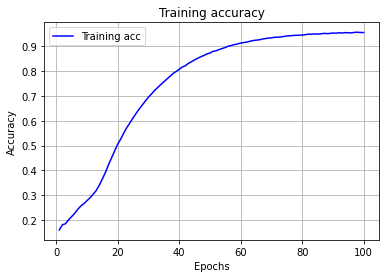

In [18]:
acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'b', label='Training acc')
# plt.plot(epochs, val_acc, 'r', label='Validation acc')
# plt.title('Training and validation accuracy')
plt.title('Training accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.show()

-----

In [19]:
from random import sample

def get_sample(text,min_len=max_seq_len):
    for _ in range(100):
        sentence = sample(text,1)[0]
        if len(sentence)>min_len:
            return sentence[:(min_len//2)]
    return [PAD,]

def encode_sentence(sentence,word2index=word2index,max_seq_len=max_seq_len-1):
    return np.array(
            pad_sequences(
                [[ word2index[token] for token in sentence ][-max_seq_len:],], 
                maxlen=max_seq_len, 
                padding='pre',
            )
        )

In [23]:
for __ in range(7):

    sentence0 = get_sample(text)
    answer = []
    sentence = sentence0.copy()

    for _ in range(17):
        sequence = encode_sentence(sentence)
        predicted_index = np.argmax( model.predict(sequence) )
        predicted_word = index2word[predicted_index]
        answer.append(predicted_word)
        if predicted_index == word2index[EOS]: break
        sentence.append(predicted_word)

    print(' '.join(sentence0)+' | ' + ' '.join(answer) )
    print(' - '*30 )    

Позвольте ( он взял прокламацию ) ; ну | да , топор и тут ; та самая , точнехонько . <EOS>
 -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  - 
Это была их первая супружеская ссора , и | случилась она тотчас после свадьбы , в самые первые медовые дни , когда вдруг обнаружился пред нею
 -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  - 
Веселым его не находили : `` человек претерпел | , человек не то что другие ; есть о чем и задуматься '' . <EOS>
 -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  - 
- Однако же , позвольте заметить , что | вы меня не уважаете ; если я и не мог докончить мысль , что там будете было
 -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  - 
Николай Всеволодович осмотрелся ; комната была крошечная , | низенькая ; мебель самая необходимая , стулья и диван деревянные , тоже совсем новой поделки , без
 -  -  -  -  